Back to the [Artificial Neural Network+ Notebook](./ann-ramp_exploit.ipynb)

Back to the [ML Notebook](./ml.ipynb)

To the [README](./README.md)

--------------------------------------------------------------------------------

# ARIMAX

In this notebook we want to create a forecast-style prediction for the power
output of the power plants.  But because the model we intend to employ are
computationally *very* expensive, we need to drastically reduce the amount
of data we process as well as the number of predictions we make.

As a result, the metrics obtained at the end of the notebook do not compare
to the ones obtained in the previous notebooks, but need to be taken and
discussed specifically for this very scenario here.

Let's start as we did with all the other notebooks before as usual:

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_theme(style='whitegrid', context='paper')

In [2]:
# load the training and testing data
df_train = [
    pd.read_csv(f'data/df_train_forecast_{loc}.csv', index_col=0)
    for loc in range(1, 5)
]
df_test = [
    pd.read_csv(f'data/df_test_forecast_{loc}.csv', index_col=0)
    for loc in range(1, 5)
]

We could use ARIMA to try and predict the power output just based on the
behaviour of the target column itself, hoping we would identify an underlying
pattern that can be predicted.

The idea for ARIMAX, however, is to feed the model additional parameters it
can use for its predictions. In our case this is basically the whole point:
we want to make power predictions based on weather conditions, so the
exogenous data we would give it are the meteorological information we have.

However, due to ARIMAX being computationally expensive, we need to boil the
data we provide down significantly to, say, at most two features.

On top of that, we will focus only on one location moving forward, as each
location would need its own analysis, get its individual ARIMA orders, etc.
We choose to focus on *location 1* from now on.

## Feature Selection

In our past analysis, we found the following features to be the most informative
for the power output:

In [3]:
# define a small set of features as parameters; the model is computationally
# extremely costly shouldn't operate on all the data!
features_ = [
    'windspeed_10m_n',
    'windspeed_100m_n',
    'winddirection_10m_s',
    'winddirection_10m_c',
    'winddirection_100m_s',
    'winddirection_100m_c',
    'windgusts_10m_n',
    'temperature_2m_n',
    'relativehumidity_2m_n',
]

To showcase how they interact with the power output, have a look at the following
plots:

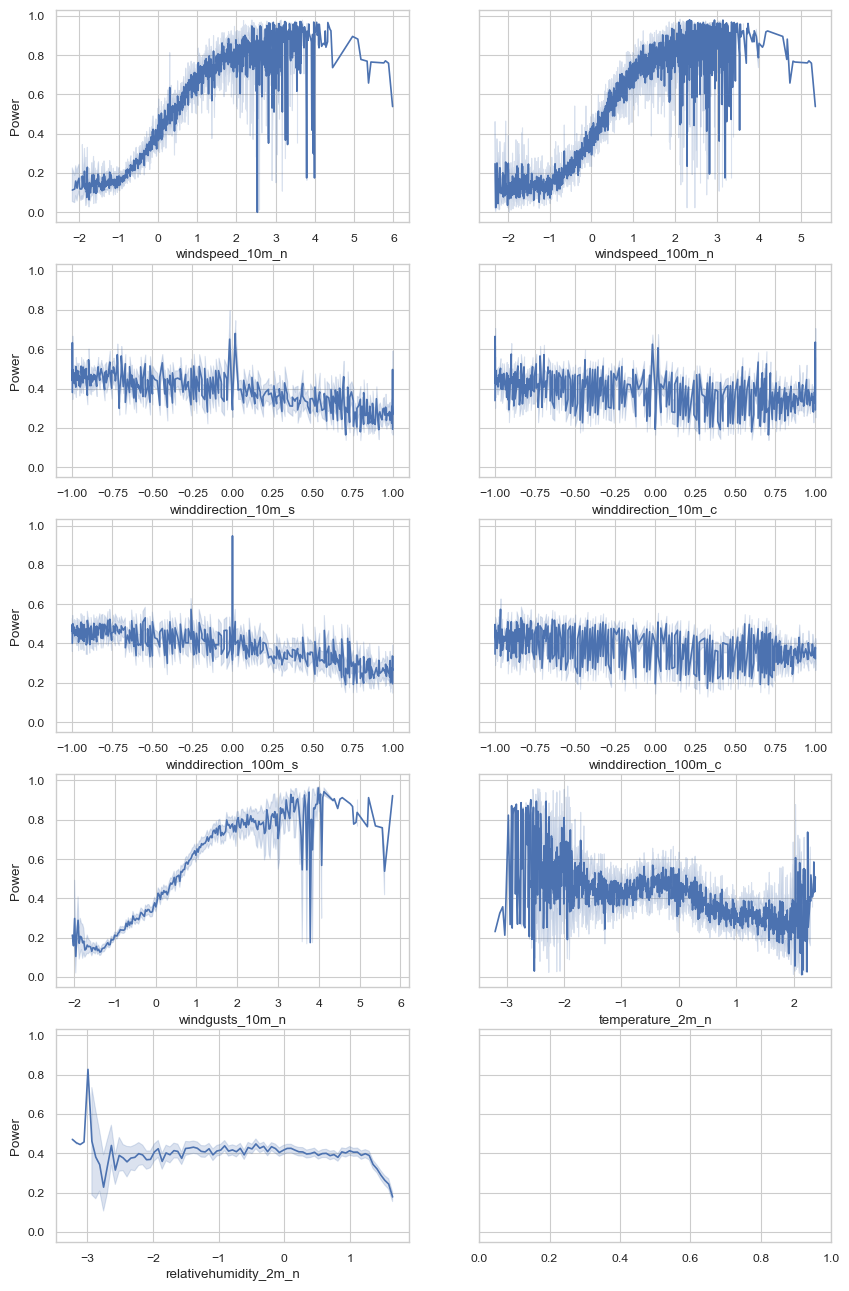

In [4]:
fig, _ = plt.subplots(5, 2, sharey=True)
fig.set_size_inches(10, 16)
for idx, feature in enumerate(features_):
    plt.subplot(5, 2, idx+1)
    sns.lineplot(df_train[0][[feature, 'Power']], x=feature, y='Power')
plt.show()

From that, we can see that `windgusts_10m_n` and one of the `windspeed_Xm_n`
features seem to be promising candidates to feed our ARIMAX model.

In [5]:
# final choice for the features
features = [
    'windspeed_100m_n',
    'windgusts_10m_n',
]

## Further Reducing the Size of the Dataset

Originally, we prepared a training and verification dataset for the forecast
case in the [EDA Notebook](./eda.ipynb).  But it turns out that those are
far too big for our model to handle reasonably.  Thus, we define two limitations
to reduce the amount of workload (at the expense of predictive capabilities
of the model, mind).

First, we limit the training data to the last three months worth of records
to learn from.  Second, we allow a prediction for not more than two days.
Recall that the records represent an hourly observation each.

In [6]:
limit = 3*30*24         # limit to the latest `limit` records (three months)
forecast_window = 24*2  # two days

## Setting up Training and Verification Data

From here, we proceed straight-forward to reduce our data frames to the
subsets we want to use:

In [7]:
# define target and features
X_train = df_train[0][features]
y_train = df_train[0].Power

X_test = df_test[0][features]
y_true = df_test[0].Power

The $y$ values are our endogenous datasets, the $X$ values our exogenous.
Here, we will apply our limits:

In [8]:
endog = y_train[-limit:]
exog = sm.add_constant(X_train[-limit:])

## Estimating the Orders for ARIMAX

There fantastic articles available as to estimate ARIMA orders based on
ACF and PACF plots, for instance: https://people.duke.edu/~rnau/411arim3.htm.

In our case, however, since we are going to use exogenous data as well, it
is a bit more tricky to find a combination of orders that work well with our
data.

We can still use ACF and PACF plots to get an estimate for starting values.
Let's first have a look at those for our target column and our features.

In [9]:
num_lags = 30   # number of lags to display in the plots

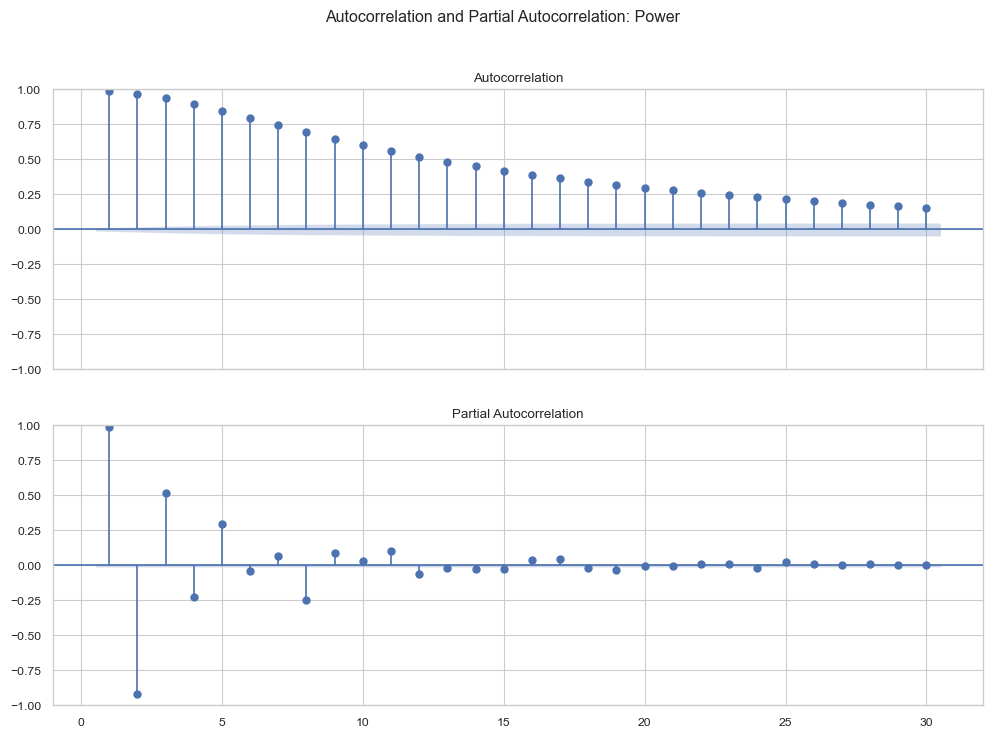

In [10]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

plot_acf(y_train, lags=num_lags, zero=False, ax=ax0)
plot_pacf(y_train, lags=num_lags, zero=False, ax=ax1)
plt.suptitle('Autocorrelation and Partial Autocorrelation: Power')
plt.show()

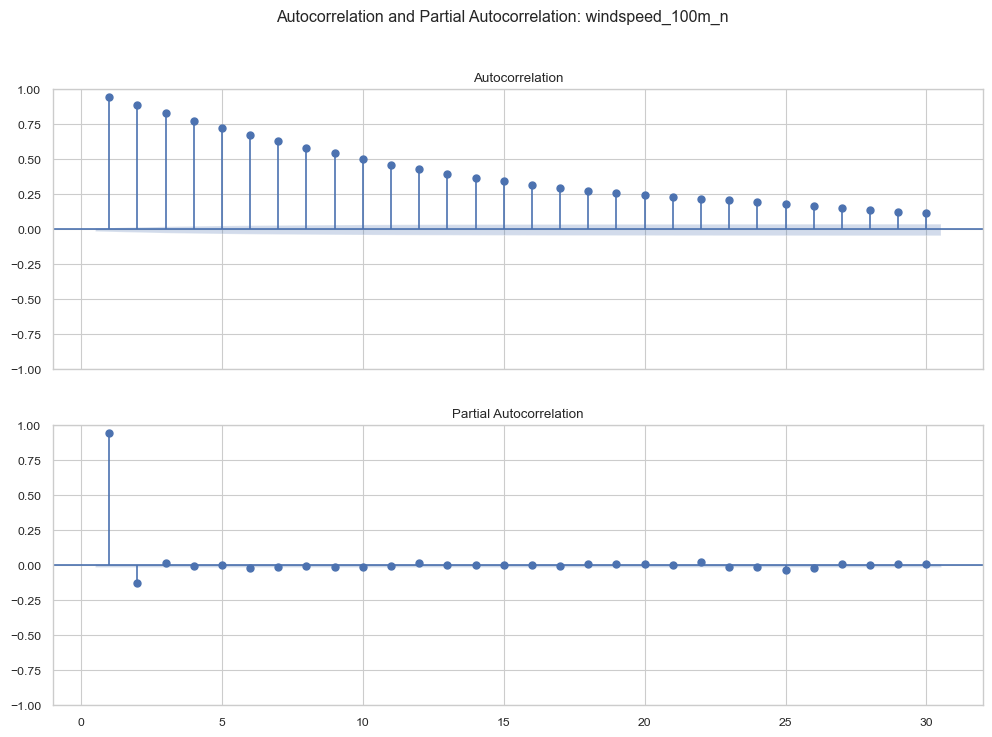

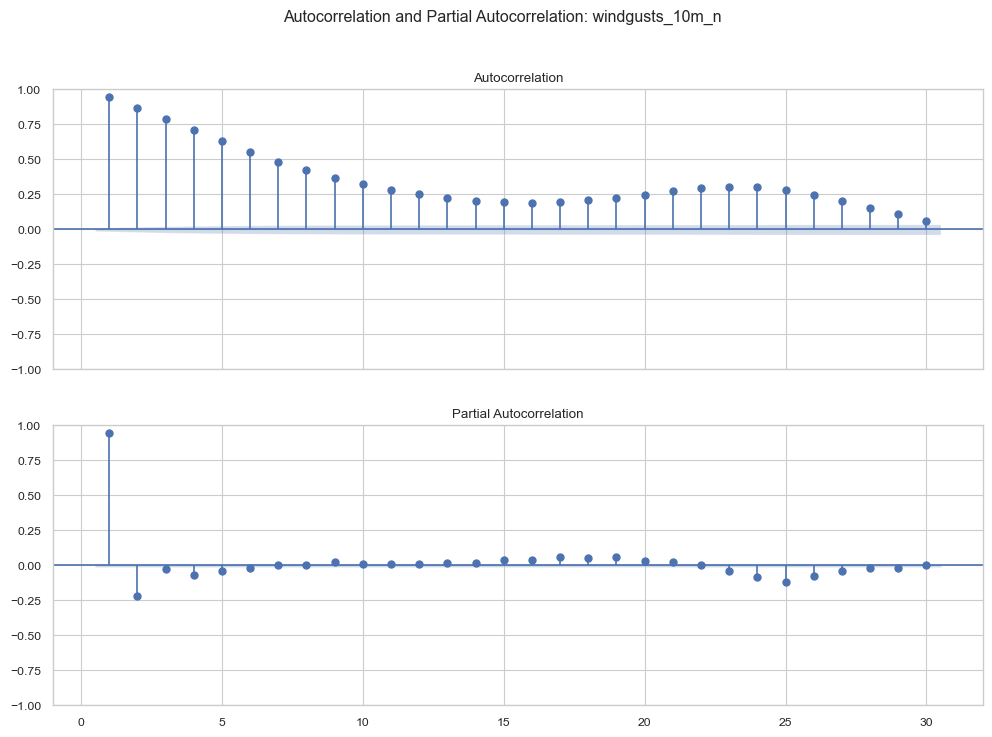

In [11]:
for feature in features:
    _, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

    plot_acf(X_train[feature], lags=num_lags, zero=False, ax=ax0)
    plot_pacf(X_train[feature], lags=num_lags, zero=False, ax=ax1)
    plt.suptitle(f'Autocorrelation and Partial Autocorrelation: {feature}')
    plt.show()

Now, we need to differentiate our data in order to make it stationary.  This
is simply done by calling `.diff()` on the series or frame:

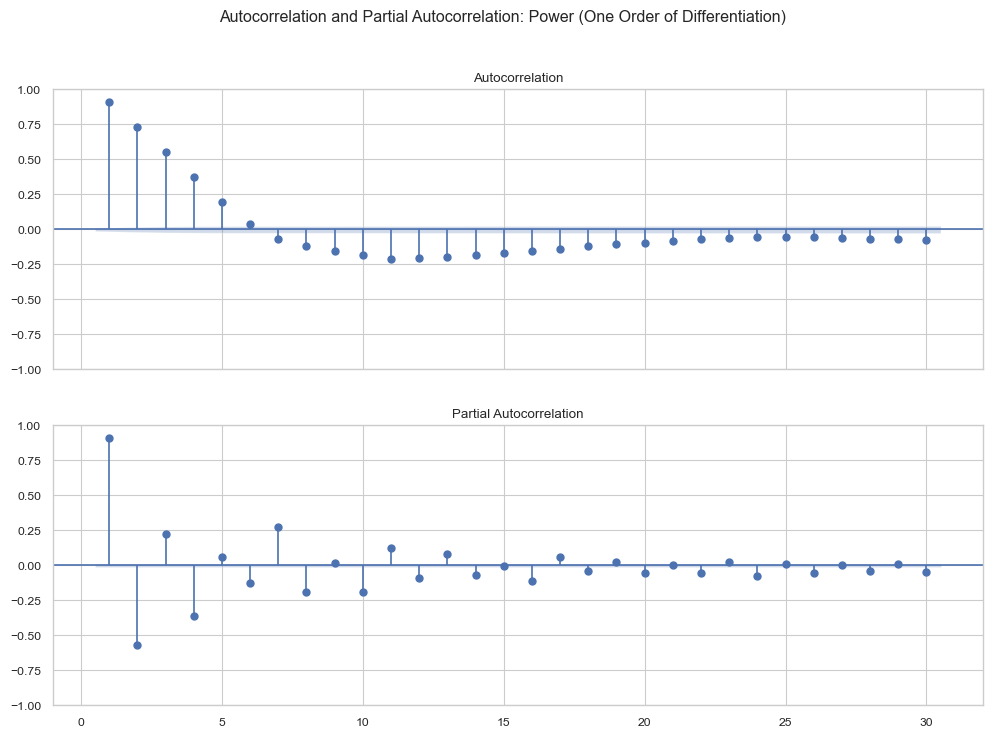

In [252]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

plot_acf(y_train.diff().dropna(), lags=num_lags, zero=False, ax=ax0)
plot_pacf(y_train.diff().dropna(), lags=num_lags, zero=False, ax=ax1)
plt.suptitle('Autocorrelation and Partial Autocorrelation: Power (One Order of Differentiation)')
plt.show()

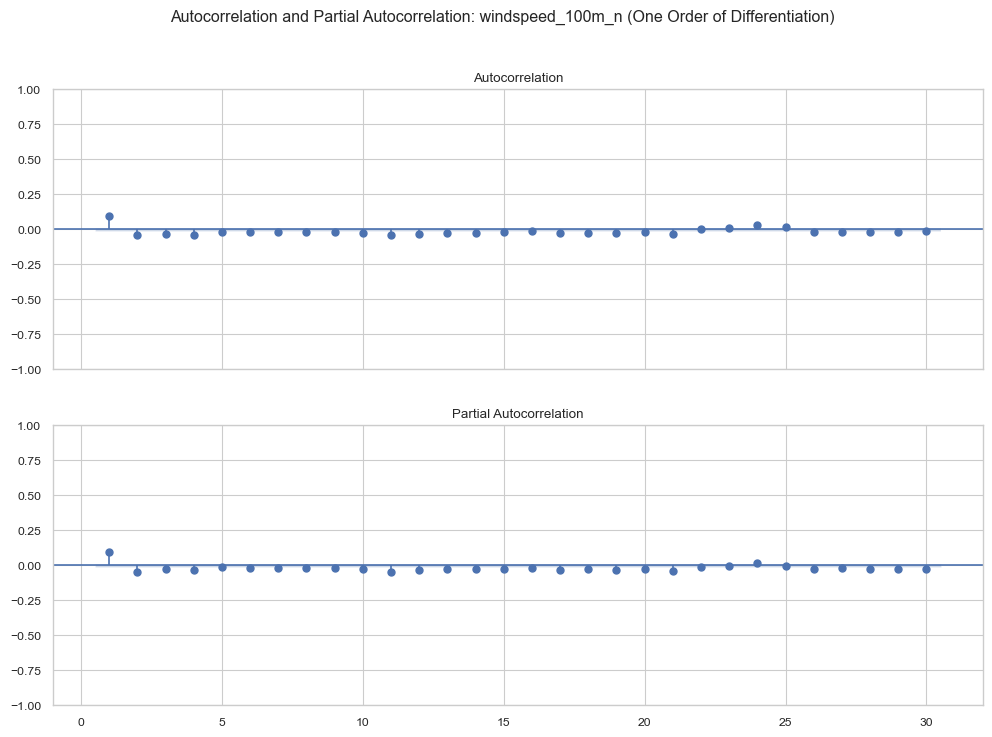

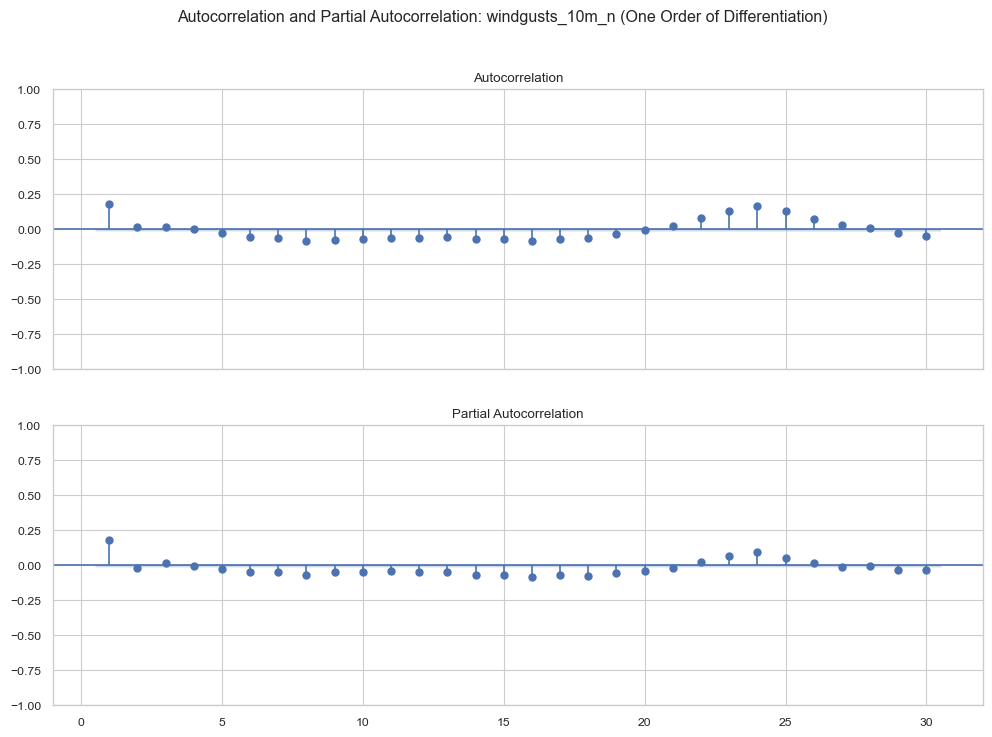

In [253]:
for feature in features:
    _, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

    plot_acf(X_train[feature].diff().dropna(), lags=num_lags, zero=False, ax=ax0)
    plot_pacf(X_train[feature].diff().dropna(), lags=num_lags, zero=False, ax=ax1)
    plt.suptitle(f'Autocorrelation and Partial Autocorrelation: {feature} (One Order of Differentiation)')
    plt.show()

We can see now that while our two endogenous sets are stationary now, this
is not true for our target data!  Furthermore, we see that there is some
seasonality going on, indicated by increased partial outocorrelations around
lag 24 (daily cycles).  And we would find more if we would increase the number
of displayed lags.

If we differentiate the power a second time, though, we find that we are
approaching the stationary case:

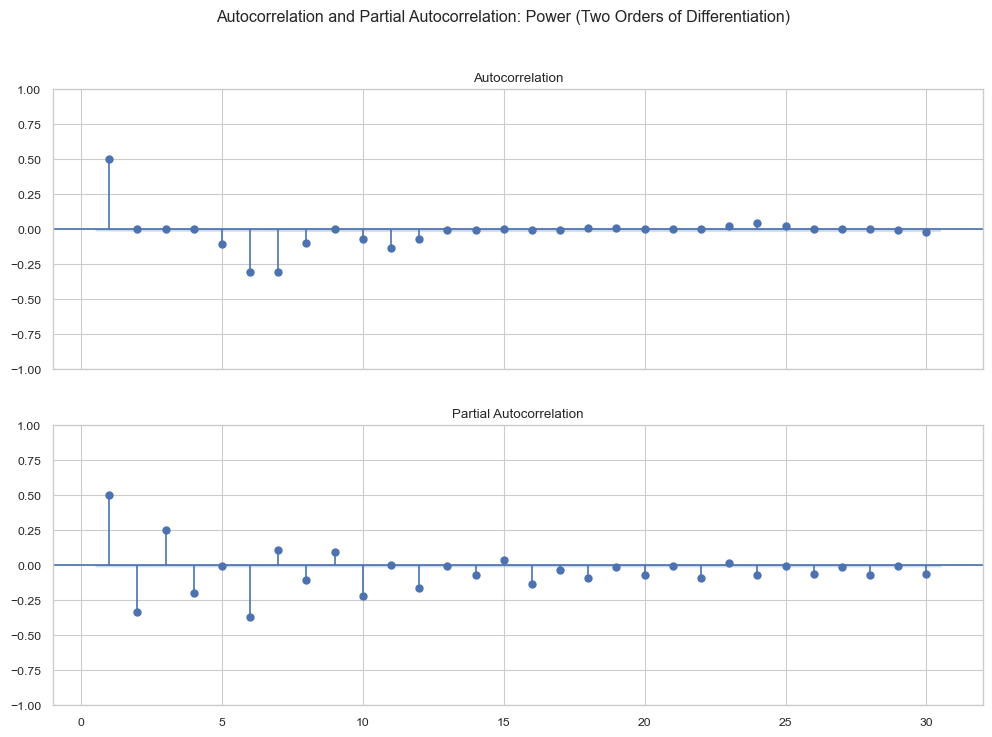

In [254]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

plot_acf(y_train.diff().diff().dropna(), lags=num_lags, zero=False, ax=ax0)
plot_pacf(y_train.diff().diff().dropna(), lags=num_lags, zero=False, ax=ax1)
plt.suptitle('Autocorrelation and Partial Autocorrelation: Power (Two Orders of Differentiation)')
plt.show()

Based on the recommendations given in the previous source, we would prefer
an AR term over an MA term, with an order of at least four (which is the last
lag before the partial autocorrelation function cuts off), that is, trying
out an ARIMA(4, 2, 1) model.  Similarly, if we give our exogenous data more
weight in the matter, an ARIMA(4, 1, 6) might be helpful as well, as might
ARIMA(5, 0, 30) if we ignore stationarity altogether.  (Note that there is
so much seasonality going on in the data that defining a proper "cut-off"
as is discussed in the source given above is rather difficult and ambiguous
in our case.  That is why we should treat those estimates as just prototypes
or starting points to go with.)

In practice, we would like to avoid higher orders as far as possible since
they impose quite the burden on our complexity and thus on the computation
time.  But for the sake of coverage, we try all three of them out:

In [226]:
# define the orders for the ARIMAX model
orders = [
    (4, 2, 1),
    (4, 1, 6),
    (5, 0, 30),
]

from warnings import simplefilter
from statsmodels.tools.sm_exceptions import ValueWarning
simplefilter('ignore', ValueWarning)

# instantiate ARIMAX models
arimax = [
    SARIMAX(
        endog=endog,
        exog=exog,
        order=order,
        enforce_stationarity=True,
        enforce_invertibility=False
    ) for order in orders
]

In [227]:
result = [model.fit(disp=False, maxiter=200) for model in arimax]

/Users/wolf/0-Projects/Wind-Power-DS/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [228]:
# make predictions
exog_pred = sm.add_constant(X_test[:forecast_window])
forecast = [
    model.get_forecast(steps=forecast_window, exog=exog_pred)
    for model in result
]

In [229]:
data = y_true[:forecast_window].to_frame()
for (order, model) in zip(orders, forecast):
    data[f'Predicted {order}'] = model.predicted_mean
data.head()

,Power,"Predicted (4, 2, 1)","Predicted (4, 1, 6)","Predicted (5, 0, 30)"
Time,,,,
2020-10-01 18:00:00,0.3172,0.319068,0.316165,0.315434
2020-10-01 19:00:00,0.3299,0.333718,0.321817,0.320382
2020-10-01 20:00:00,0.3427,0.348392,0.324507,0.321321
2020-10-01 21:00:00,0.3554,0.363072,0.329857,0.321069
2020-10-01 22:00:00,0.3681,0.377742,0.338179,0.320582


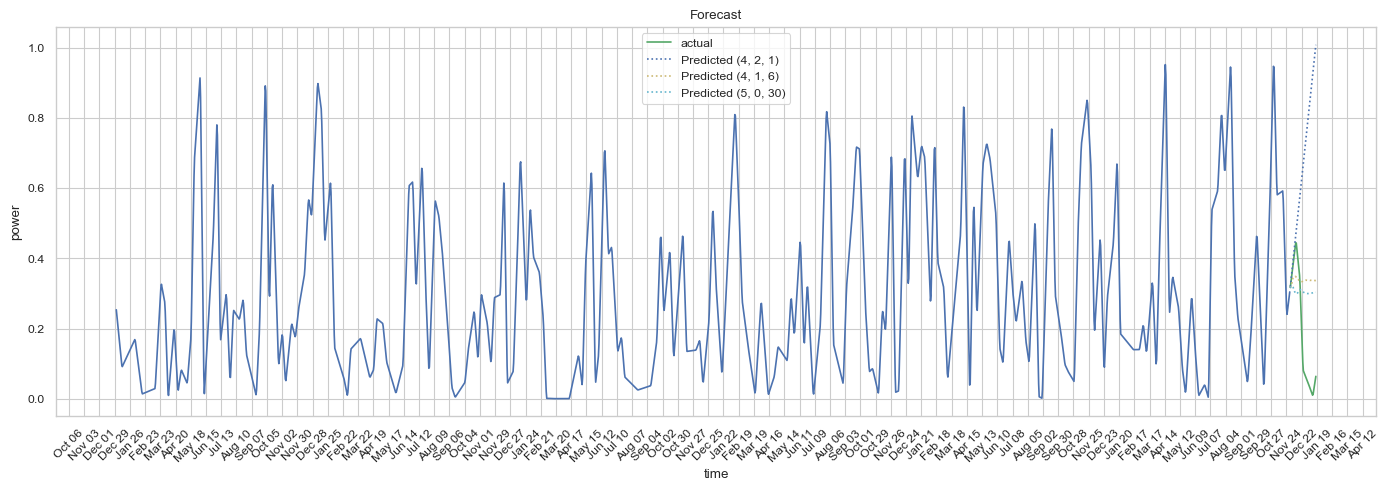

In [230]:
plt.figure(figsize=(14,5))
sns.lineplot(y_train[-limit:], errorbar=None)
plt.plot(data['Power'], 'g-', label='actual')
for (column, color) in zip(data.columns[1:], ['b', 'y', 'c']):
    plt.plot(data[column], f'{color}:', label=column)
plt.legend()
plt.xlabel('time')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.ylabel('power')
plt.title('Forecast')
plt.tight_layout()
plt.show()

In [231]:
# evaluate results
error = [
    (column[10:], root_mean_squared_error(data['Power'], data[column]))
    for column in data.columns[1:]
]

for (order, err) in error:
    print(f'{order}:\tRMSE = {err:.3f}')

(4, 2, 1):	RMSE = 0.590
(4, 1, 6):	RMSE = 0.217
(5, 0, 30):	RMSE = 0.196


None of those scores look particularly promising, and neither does any of
the forecast plots.  In fact, ARIMA(4, 2, 1) even fails to converge within
200 iterations!  But searching around those inital parameters (for
instance using Grid Search) one may find a model with a remarkably low
Root Mean Square Error:

In [234]:
new_orders = [
    (4, 0, 14),
    (4, 0, 18),
]

new_arimax = [
    SARIMAX(
        endog=endog,
        exog=exog,
        order=order,
        enforce_stationarity=True,
        enforce_invertibility=False
    ) for order in new_orders
]

In [235]:
new_result = [model.fit(disp=False, maxiter=200) for model in new_arimax]

In [236]:
# make predictions
new_forecast = [
    model.get_forecast(steps=forecast_window, exog=exog_pred)
    for model in new_result
]

In [240]:
new_data = y_true[:forecast_window].to_frame()
for (order, model) in zip(new_orders, new_forecast):
    new_data[f'Predicted {order}'] = model.predicted_mean
new_data.head()

,Power,"Predicted (4, 0, 14)","Predicted (4, 0, 18)"
Time,,,
2020-10-01 18:00:00,0.3172,0.313495,0.315462
2020-10-01 19:00:00,0.3299,0.313340,0.317556
2020-10-01 20:00:00,0.3427,0.309208,0.317648
2020-10-01 21:00:00,0.3554,0.305252,0.319002
2020-10-01 22:00:00,0.3681,0.301810,0.318583


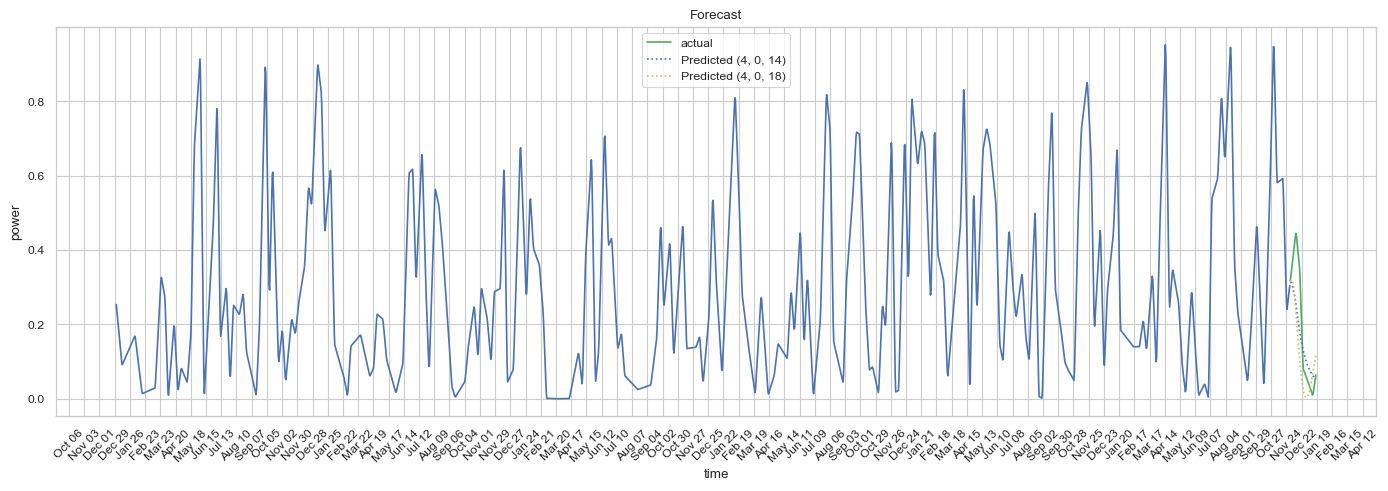

In [241]:
plt.figure(figsize=(14,5))
sns.lineplot(y_train[-limit:], errorbar=None)
plt.plot(new_data['Power'], 'g-', label='actual')
for (column, color) in zip(new_data.columns[1:], ['b', 'y']):
    plt.plot(new_data[column], f'{color}:', label=column)
plt.legend()
plt.xlabel('time')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.ylabel('power')
plt.title('Forecast')
plt.tight_layout()
plt.show()

In [242]:
# evaluate results
new_error = [
    (column[10:], root_mean_squared_error(new_data['Power'], new_data[column]))
    for column in new_data.columns[1:]
]

for (order, err) in new_error:
    print(f'{order}:\tRMSE = {err:.3f}')

(4, 0, 14):	RMSE = 0.096
(4, 0, 18):	RMSE = 0.122


As it turns out, models without differentiation and a relatively large MA
order appear to be suited for short-term predictions, as the previous plot
showcases.  At least for our case.  If one would increase the window for
the predictions to, say, three days or beyond, the scores would worsen
significantly.

It is important to understand that those particular set of orders only works
for this particular configuration of training and verification data.  That
is, unsurprisingly, trying out the same models for any of the other locations
would lead to scores as bad as we had with our prototypes.  But the ties to
this particular data configuration goes even deeper:  If we were to replace
the `windspeed_100m_n` column with the `windspeed_10m_n` column, which, on
the surface, should actually convey the same sort of information, then this
happens:

In [243]:
# final choice for the features
new_features = [
    'windspeed_10m_n',
    'windgusts_10m_n',
]

In [244]:
new_X_train = df_train[0][new_features]
new_X_test = df_test[0][new_features]

In [245]:
new_exog = sm.add_constant(new_X_train[-limit:])

In [246]:
yet_new_arimax = [
    SARIMAX(
        endog=endog,
        exog=new_exog,
        order=order,
        enforce_stationarity=True,
        enforce_invertibility=False
    ) for order in new_orders
]

In [247]:
yet_new_result = [model.fit(disp=False, maxiter=200) for model in yet_new_arimax]

In [248]:
# make predictions
new_exog_pred = sm.add_constant(new_X_test[:forecast_window])
yet_new_forecast = [
    model.get_forecast(steps=forecast_window, exog=new_exog_pred)
    for model in yet_new_result
]

In [249]:
yet_new_data = y_true[:forecast_window].to_frame()
for (order, model) in zip(new_orders, yet_new_forecast):
    yet_new_data[f'Predicted {order}'] = model.predicted_mean
yet_new_data.head()

,Power,"Predicted (4, 0, 14)","Predicted (4, 0, 18)"
Time,,,
2020-10-01 18:00:00,0.3172,0.313740,0.313806
2020-10-01 19:00:00,0.3299,0.313116,0.313174
2020-10-01 20:00:00,0.3427,0.309074,0.308503
2020-10-01 21:00:00,0.3554,0.307139,0.305649
2020-10-01 22:00:00,0.3681,0.307287,0.305264


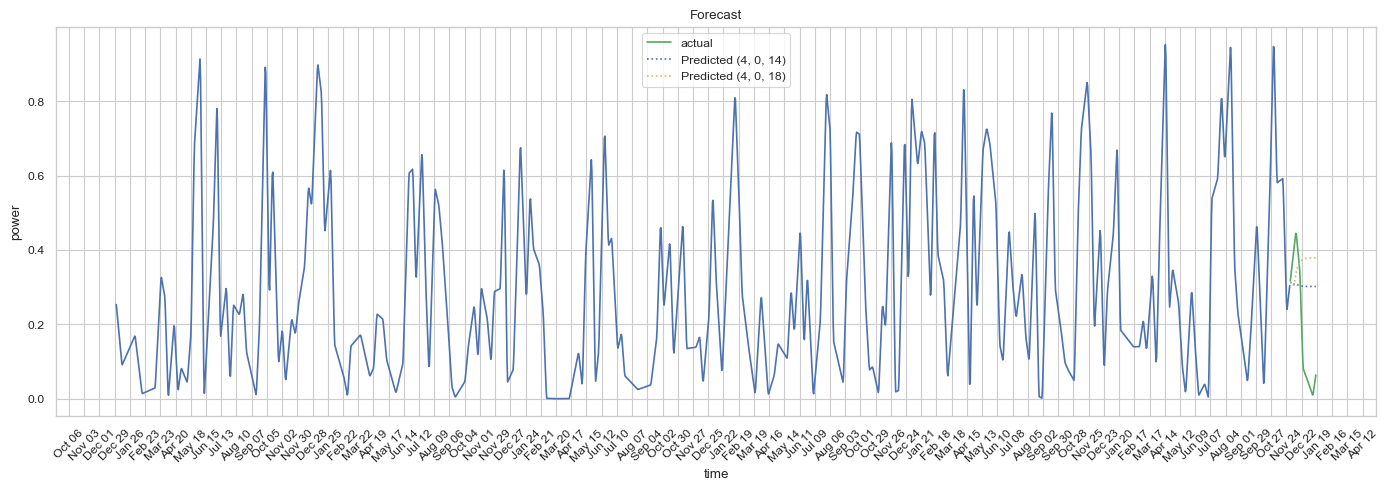

In [250]:
plt.figure(figsize=(14,5))
sns.lineplot(y_train[-limit:], errorbar=None)
plt.plot(new_data['Power'], 'g-', label='actual')
for (column, color) in zip(yet_new_data.columns[1:], ['b', 'y']):
    plt.plot(yet_new_data[column], f'{color}:', label=column)
plt.legend()
plt.xlabel('time')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.ylabel('power')
plt.title('Forecast')
plt.tight_layout()
plt.show()

In [251]:
# evaluate results
yet_new_error = [
    (column[10:], root_mean_squared_error(yet_new_data['Power'], yet_new_data[column]))
    for column in yet_new_data.columns[1:]
]

for (order, err) in yet_new_error:
    print(f'{order}:\tRMSE = {err:.3f}')

(4, 0, 14):	RMSE = 0.195
(4, 0, 18):	RMSE = 0.249


The scores are as bad as those of our prototypes.  This emphasizes the tightness
with which the ARIMAX orders are tied to the particular dataset!

But of course, we must not forget that we already stated in the beginning that
ARIMAX is *not* an ideal model for what we are dealing with in the first place:
we never addressed the underlying seasonality (SARIMAX) and only mentioned that
there is even more going on than what we discussed with our ACF and PACF plots.

Another important point to discuss is:  Is ARIMAX (in general) a practically
applicable model for this case in real life?  The problem is that we want to
make a forecast here, but this forecast needs exogenous information from the
future as well: the meteorological data.  Since we would use forecast models
to predict *them* first, probably with higher precision than with what we
showcased here in this notebook, it would make more sense to remove the forecast
element from the power prediction again.  First, because the work will already
have been done, and second, it adds an additional source of uncertainty to
the problem thanks to an unnecessarily inflated complexity of the whole system.

--------------------------------------------------------------------------------

Back to the [ML Notebook](./ml.ipynb)

Back to the [README](./README.md)